In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pylab import rcParams
import statsmodels.api as sm

import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing



import warnings
warnings.filterwarnings('ignore')

In [285]:
bcoin = pd.read_csv('bitcoin.csv', header = None)

In [286]:
print(bcoin.shape)
bcoin.head()

(32, 2)


,0,1
0,0,217.4
1,1,255.7
2,2,244.3
3,3,236.1
4,4,228.7


In [287]:
bcoin.columns = ['months', 'price']
print(bcoin.info())
bcoin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
months    32 non-null int64
price     32 non-null float64
dtypes: float64(1), int64(1)
memory usage: 640.0 bytes
None


,months,price
0,0,217.4
1,1,255.7
2,2,244.3
3,3,236.1
4,4,228.7


In [288]:
bcoin = bcoin.set_index('months')
bcoin.head()

,price
months,
0,217.4
1,255.7
2,244.3
3,236.1
4,228.7


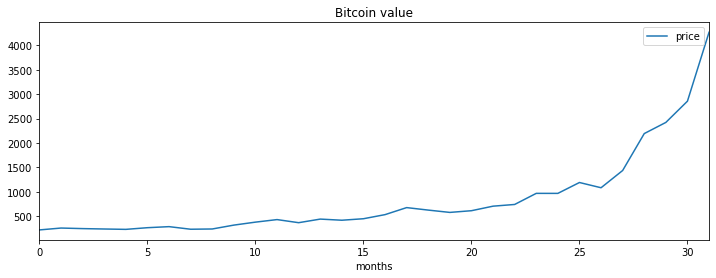

In [289]:
bcoin.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Bitcoin value')
plt.show(block=False)

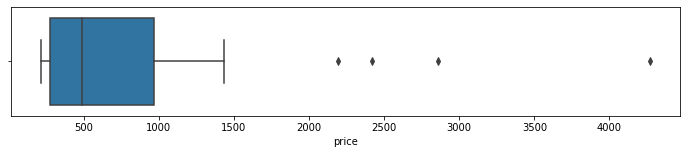

In [290]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=bcoin['price'],whis=1.5)

In [291]:
train_len = 29
train = bcoin[0:train_len]
test = bcoin[train_len:]
print(train.shape)
print(test.shape)
train.transpose

(29, 1)
(3, 1)


<bound method DataFrame.transpose of          price
months        
0        217.4
1        255.7
2        244.3
3        236.1
4        228.7
5        262.9
6        284.5
7        231.4
8        236.5
9        316.0
10       376.9
11       429.0
12       365.5
13       439.2
14       416.0
15       446.6
16       530.7
17       674.7
18       623.7
19       576.2
20       611.1
21       704.1
22       739.0
23       966.6
24       966.2
25      1189.1
26      1081.7
27      1435.2
28      2191.8>

In [292]:
test.transpose

<bound method DataFrame.transpose of          price
months        
29      2420.7
30      2856.0
31      4268.8>

### Naive

In [293]:
yhat_est = test.copy()
print(yhat_est)
print(type(yhat_est))
yhat_est['naiveFC'] = train['price'][train_len - 1]
print(len(yhat_est.naiveFC))
yhat_est

         price
months        
29      2420.7
30      2856.0
31      4268.8
<class 'pandas.core.frame.DataFrame'>
3


,price,naiveFC
months,,
29,2420.7,2191.8
30,2856.0,2191.8
31,4268.8,2191.8


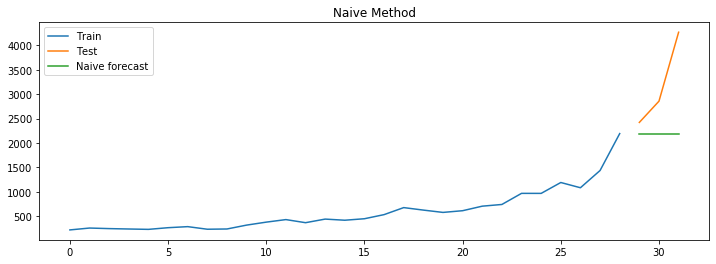

In [294]:
plt.figure(figsize=(12,4))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_est['naiveFC'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [295]:
print(yhat_est)

         price  naiveFC
months                 
29      2420.7   2191.8
30      2856.0   2191.8
31      4268.8   2191.8


### Simple Average

In [296]:
print(bcoin.price.mean())
print(train.price.mean())

838.1968750000001
595.7517241379311


In [297]:
yhat_est['yhat_sa'] = train['price'].mean() 

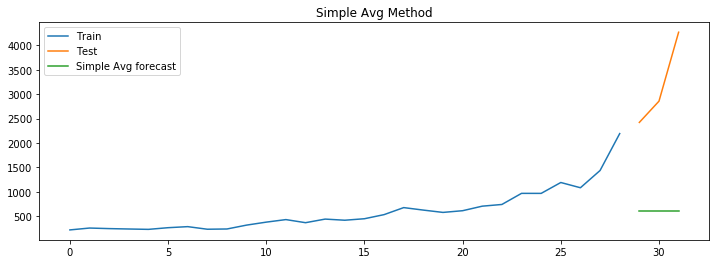

In [298]:
plt.figure(figsize=(12,4))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_est['yhat_sa'], label='Simple Avg forecast')
plt.legend(loc='best')
plt.title('Simple Avg Method')
plt.show()

In [299]:
yhat_est

,price,naiveFC,yhat_sa
months,,,
29,2420.7,2191.8,595.751724
30,2856.0,2191.8,595.751724
31,4268.8,2191.8,595.751724


In [300]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_est['naiveFC'])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_est['naiveFC'])/test['price'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.9,27.12


In [301]:
print(test['price'])
print(yhat_est['price'])
rmse = np.sqrt(mean_squared_error(test['price'], yhat_est['yhat_sa'])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_est['yhat_sa'])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

months
29    2420.7
30    2856.0
31    4268.8
Name: price, dtype: float64
months
29    2420.7
30    2856.0
31    4268.8
Name: price, dtype: float64


,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19


In [302]:
yhat_sma = bcoin.copy()
ma_window = 12
yhat_sma['sma_forecast12'] = bcoin.price.rolling(ma_window).mean()
yhat_sma['sma_forecast12'][train_len:] = yhat_sma['sma_forecast12'][train_len - 1]

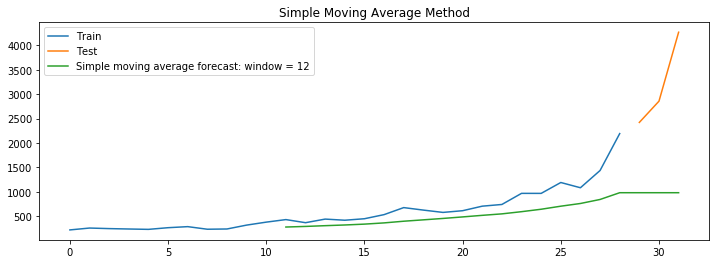

In [303]:
plt.figure(figsize=(12,4))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_sma['sma_forecast12'], label='Simple moving average forecast: window = 12')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [304]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_sma['sma_forecast12'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_sma['sma_forecast12'][train_len:])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast(12)'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42


In [305]:
ma_window = 6
yhat_sma['sma_forecast6'] = bcoin.price.rolling(ma_window).mean()
yhat_sma['sma_forecast6'][train_len:] = yhat_sma['sma_forecast6'][train_len - 1]

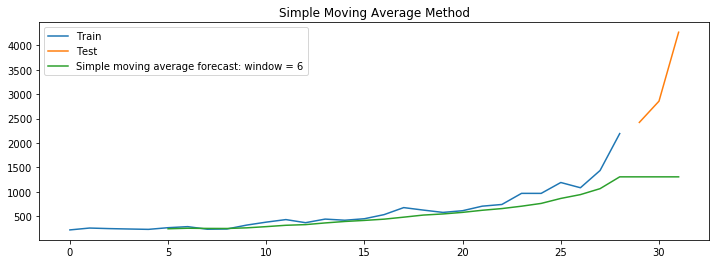

In [306]:
plt.figure(figsize=(12,4))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_sma['sma_forecast6'], label='Simple moving average forecast: window = 6')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [307]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_sma['sma_forecast6'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_sma['sma_forecast6'][train_len:])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast(6)'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42
0,Simple moving average forecast(6),2035.79,56.61


In [308]:
ma_window = 3
yhat_sma['sma_forecast3'] = bcoin.price.rolling(ma_window).mean()
yhat_sma['sma_forecast3'][train_len:] = yhat_sma['sma_forecast3'][train_len - 1]

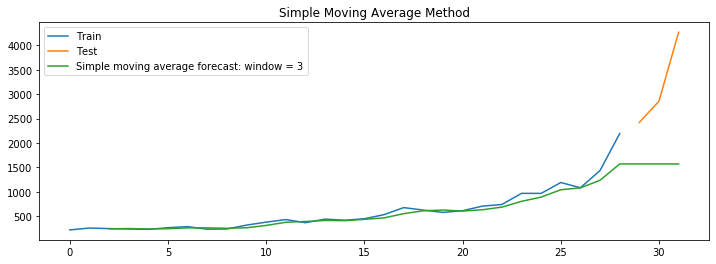

In [309]:
plt.figure(figsize=(12,4))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_sma['sma_forecast3'], label='Simple moving average forecast: window = 3')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [310]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_sma['sma_forecast3'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_sma['sma_forecast3'][train_len:])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast(3)'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42
0,Simple moving average forecast(6),2035.79,56.61
0,Simple moving average forecast(3),1794.92,47.81


In [311]:
model = SimpleExpSmoothing(train['price'])
model_fit = model.fit(optimized=True)
print(model_fit.params)
yhat_ses = test.copy()
yhat_ses['ses_forecast'] = model_fit.forecast(3)

{'smoothing_level': 1.0, 'smoothing_slope': nan, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 217.4, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


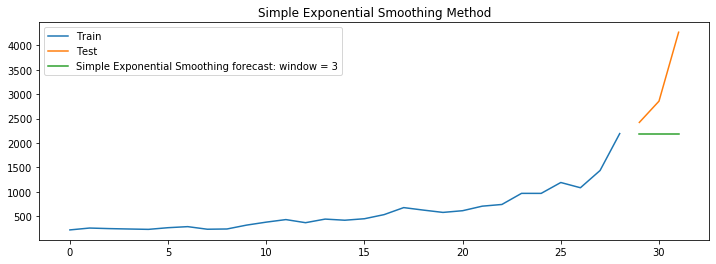

In [312]:
plt.figure(figsize=(12,4))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_ses['ses_forecast'], label='Simple Exponential Smoothing forecast: window = 3')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [313]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_ses['ses_forecast'])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42
0,Simple moving average forecast(6),2035.79,56.61
0,Simple moving average forecast(3),1794.92,47.81
0,Simple exponential smoothing forecast,1265.90,27.12


In [314]:
model = ExponentialSmoothing(np.asarray(train['price']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
yhat_holt = test.copy()
yhat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 1.0, 'smoothing_slope': 0.421665199347555, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 203.6898567333904, 'initial_slope': 13.712534816840952, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


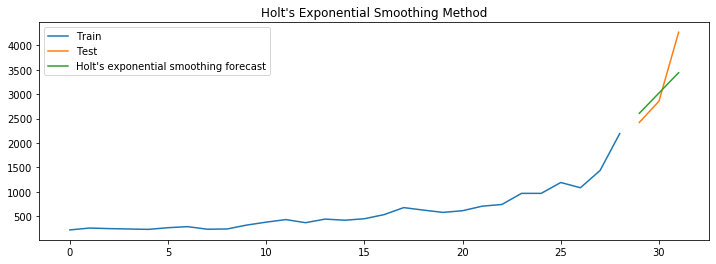

In [315]:
plt.figure(figsize=(12,4))
plt.plot( train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

In [316]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_holt['holt_forecast'])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42
0,Simple moving average forecast(6),2035.79,56.61
0,Simple moving average forecast(3),1794.92,47.81
0,Simple exponential smoothing forecast,1265.90,27.12
0,Holt's exponential smoothing method,500.11,11.01


In [317]:
yhat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['price']) ,seasonal_periods=3 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
yhat_hwa['hw_forecast'] = model_fit.forecast(3)

{'smoothing_level': 0.9999999966296118, 'smoothing_slope': 0.41588403475323543, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 559.4835559830856, 'initial_slope': 1.1415863510958597, 'initial_seasons': array([-340.14176736, -301.86534663, -319.22904421]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


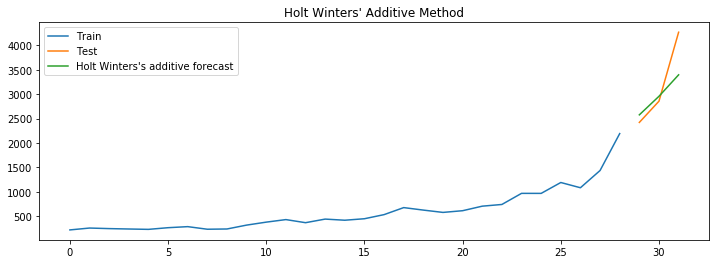

In [318]:
plt.figure(figsize=(12,4))
plt.plot( train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [319]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_hwa['hw_forecast'])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42
0,Simple moving average forecast(6),2035.79,56.61
0,Simple moving average forecast(3),1794.92,47.81
0,Simple exponential smoothing forecast,1265.90,27.12
0,Holt's exponential smoothing method,500.11,11.01
0,Holt Winters' additive method,515.11,10.12


In [320]:
yhat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['price']) ,seasonal_periods=3 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
yhat_hwm['hw_forecast'] = model_fit.forecast(3)

{'smoothing_level': 1.0, 'smoothing_slope': 0.31592231645159186, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 559.5299998374193, 'initial_slope': 1.1444444471947526, 'initial_seasons': array([0.40269358, 0.46254254, 0.41789274]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


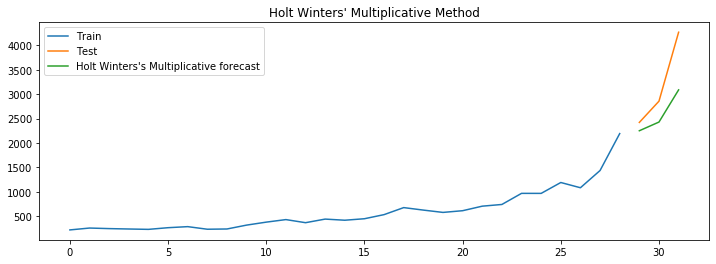

In [321]:
plt.figure(figsize=(12,4))
plt.plot( train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(yhat_hwm['hw_forecast'], label='Holt Winters\'s Multiplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Multiplicative Method')
plt.show()

In [322]:
rmse = np.sqrt(mean_squared_error(test['price'], yhat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['price']-yhat_hwm['hw_forecast'])/test['price'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' Multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,1265.90,27.12
0,Simple average method,2703.73,80.19
0,Simple moving average forecast(12),2338.94,67.42
0,Simple moving average forecast(6),2035.79,56.61
0,Simple moving average forecast(3),1794.92,47.81
0,Simple exponential smoothing forecast,1265.90,27.12
0,Holt's exponential smoothing method,500.11,11.01
0,Holt Winters' additive method,515.11,10.12
0,Holt Winters' Multiplicative method,731.90,16.57
